# Simple neural network - further extending previous ML paper
In this work, we take the work of the previous XBT ML paper and fit the classifier into the standard training and evaluation pipeline to determine its relative performance. We also use the additional input feature of lat/lon location and using the MLPClassifier class.

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets
import time

In [3]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_with_imeta',
    'pangeo': '/data/misc/xbt-data/csv_with_imeta/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}
output_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/csv_output',
    'pangeo': '/data/misc/xbt-data/csv_output/',

}
result_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/results',
    'pangeo': '/data/misc/xbt-data/results/',
}


In [8]:
output_dir = output_dirs[environment]
output_fname_template = 'xbt_output_{classifier}_{suffix}.csv'
result_dir = result_dirs[environment]
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [9]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']

In [10]:
classifier_class = sklearn.neural_network.MLPClassifier
classifier_opts = {'max_iter': 1000,
                  'hidden_layer_sizes':(10, 10,),
                   'alpha': 1e-4,
                  }
classifier_name = 'MLP'
suffix='countryLatLon'

In [11]:
%%time
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

CPU times: user 2min 3s, sys: 9.45 s, total: 2min 13s
Wall time: 6min 24s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [12]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 789 ms, sys: 23.7 ms, total: 813 ms
Wall time: 810 ms


In [13]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [14]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [15]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)

CPU times: user 32.6 ms, sys: 0 ns, total: 32.6 ms
Wall time: 30.1 ms


In [16]:
%%time
xbt_unseen = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='include', check_type='in_filter_set')
xbt_working = xbt_labelled.filter_obs({'cruise_number': unseen_cruise_numbers}, mode='exclude', check_type='in_filter_set')

CPU times: user 8.32 s, sys: 13.1 ms, total: 8.33 s
Wall time: 8.33 s


In [17]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [18]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [19]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=['instrument', 'year'])

CPU times: user 5min 25s, sys: 24 s, total: 5min 49s
Wall time: 5min 49s


In [20]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features(['instrument']).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features(['instrument']).get_ml_dataset()[0]

## Training the classifier

We are using the standard training and evaluation pipeline, using the MLPClassifier class as the estimator, with the standard imeta input features:
* country
* max_depth
* year
* latitude
* longitude

In [21]:
metrics_per_class_all = {}
metrics_avg_all = {}

In [22]:
%%time
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

CPU times: user 12min 58s, sys: 18.9 s, total: 13min 17s
Wall time: 13min 17s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [23]:
metrics_per_class_all['instrument'] = list(xbt_labelled._feature_encoders['instrument'].classes_)

In [24]:
y_res_train_instr_all = clf_dt_instr1.predict(X_train_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_train_all, y_res_train_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_train': metrics1[0],
    'recall_instr_train': metrics1[1],
    'f1_instr_train': metrics1[2],
    'support_instr_train': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_train' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_train' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_train' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [25]:
y_res_test_instr_all = clf_dt_instr1.predict(X_test_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_test_all, y_res_test_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_test': metrics1[0],
    'recall_instr_test': metrics1[1],
    'f1_instr_test': metrics1[2],
    'support_instr_test': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_test' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_test' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_test' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [26]:
y_res_unseen_instr_all = clf_dt_instr1.predict(X_unseen_all)
metrics1 = sklearn.metrics.precision_recall_fscore_support(y_instr_unseen_all, y_res_unseen_instr_all, labels=list(range(0,len(metrics_per_class_all['instrument']))))
metrics_per_class_all.update( {
    'precision_instr_unseen': metrics1[0],
    'recall_instr_unseen': metrics1[1],
    'f1_instr_unseen': metrics1[2],
    'support_instr_unseen': metrics1[3],
})
metrics_avg_all.update({
    'precision_instr_unseen' : sum(metrics1[0] * metrics1[3])/ sum(metrics1[3]),
    'recall_instr_unseen' : sum(metrics1[1] * metrics1[3])/ sum(metrics1[3]),
    'f1_instr_unseen' : sum(metrics1[2] * metrics1[3])/ sum(metrics1[3]),
})

In [27]:
df_metrics_per_class_instr = pandas.DataFrame.from_dict({k1:v1 for k1,v1 in metrics_per_class_all.items() if 'instr' in k1})

In [28]:
df_metrics_avg = pandas.DataFrame.from_dict({
    'target': ['instrument_train','instrument_test', 'instrument_unseen'],
    'precision': [v1 for k1,v1 in metrics_avg_all.items() if 'precision' in k1],
    'recall': [v1 for k1,v1 in metrics_avg_all.items() if 'recall' in k1],
    'f1': [v1 for k1,v1 in metrics_avg_all.items() if 'f1' in k1],
})

In [29]:
df_metrics_avg

,target,precision,recall,f1
0,instrument_train,0.879716,0.883386,0.878658
1,instrument_test,0.879220,0.882601,0.877930
2,instrument_unseen,0.872037,0.873285,0.867999


# Classification result plots

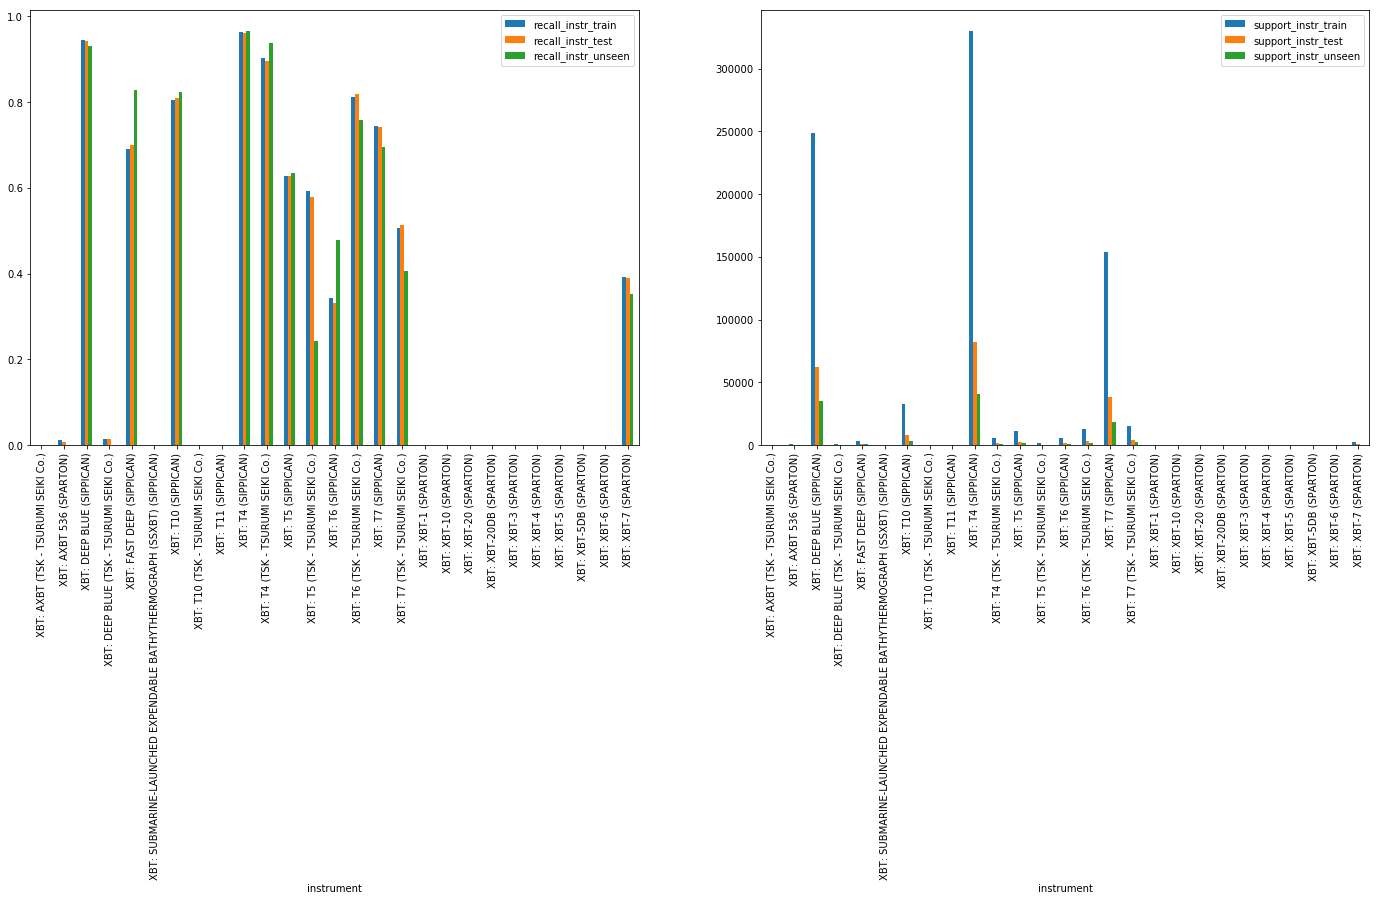

In [30]:
fig_results_all_dt = matplotlib.pyplot.figure('xbt_results_all_dt', figsize=(24,8))
axis_instr_metrics = fig_results_all_dt.add_subplot(121)
_ = df_metrics_per_class_instr.plot.bar(x='instrument', y=['recall_instr_train','recall_instr_test','recall_instr_unseen'],ax=axis_instr_metrics)
axis_instr_support = fig_results_all_dt.add_subplot(122)
_ = df_metrics_per_class_instr.plot.bar(x='instrument',y=['support_instr_train', 'support_instr_test', 'support_instr_unseen'], ax=axis_instr_support)


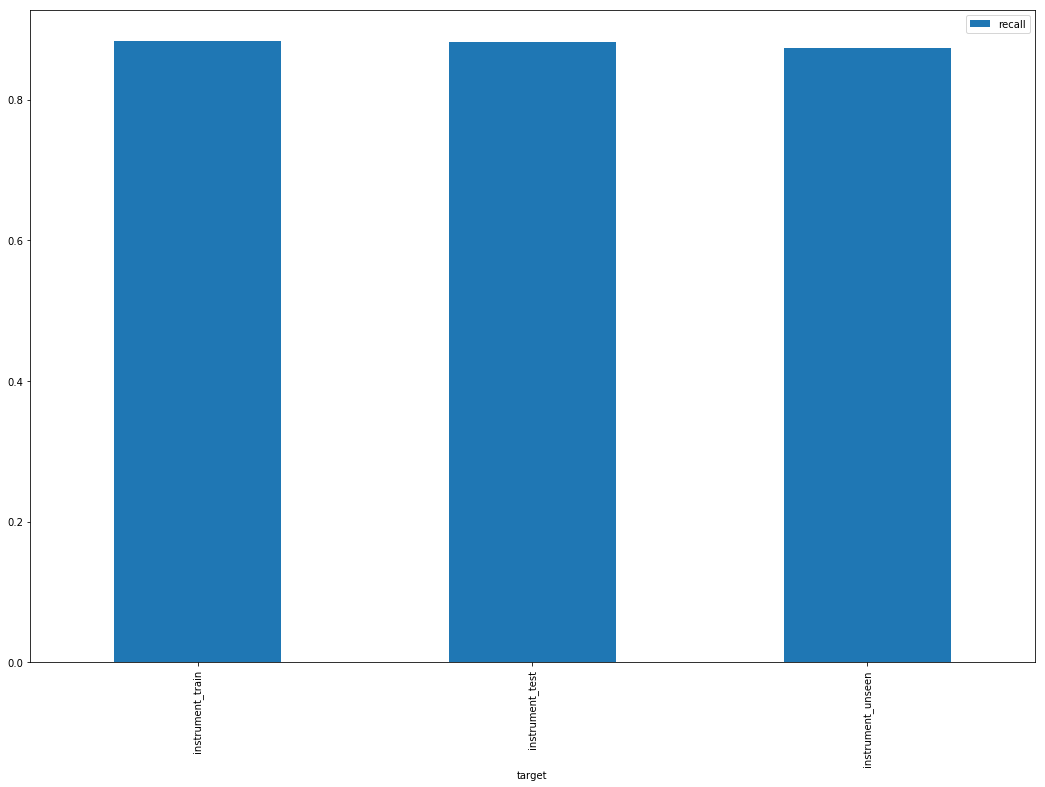

In [31]:
df_metrics_avg.plot.bar(figsize=(18,12), x='target', y='recall')

## Classification results

The contents of the XBT dataset varies over the time period, so previous papers have looked at classification accuracy (recall) year by year to evaluate how performance varies with different distribution of probe types.

To do this we apply the classifier to the train and test data for each year separetly and calculate the metrics year by year.

In [32]:
def score_year(xbt_df, year, clf, input_features, target_feature):
    X_year = xbt_df.filter_obs({'year': year}, ).filter_features(input_features).get_ml_dataset()[0]
    y_year = xbt_df.filter_obs({'year': year} ).filter_features([target_feature]).get_ml_dataset()[0]
    y_res_year = clf.predict(X_year)
    metric_year = sklearn.metrics.precision_recall_fscore_support(
        y_year, y_res_year, average='micro')
    return metric_year

In [33]:
eval_progress = ipywidgets.IntProgress(min=env_date_ranges[environment][0],
                                           max= env_date_ranges[environment][1],
                                          description='Evaluating',
                                          bar_style='info')
eval_progress

IntProgress(value=1966, bar_style='info', description='Evaluating', max=2015, min=1966)

In [34]:
results_by_year = {}

In [35]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    results_by_year[year] = {
        'metric_train_instr' : score_year(xbt_train_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_test_instr' : score_year(xbt_test_all, year, clf_dt_instr1, input_feature_names, 'instrument'),
        'metric_unseen_instr' : score_year(xbt_unseen, year, clf_dt_instr1, input_feature_names, 'instrument'),
    }
    eval_progress.value = year


In [36]:
recall_by_year = pandas.DataFrame.from_dict({ 
    'year':  list(results_by_year.keys()),
    'recall_train_instr' : [m1['metric_train_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_test_instr' : [m1['metric_test_instr'][1] for y1,m1 in results_by_year.items()],
    'recall_unseen_instr' : [m1['metric_unseen_instr'][1] for y1,m1 in results_by_year.items()],
})


In [37]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [38]:
eval_progress.value = env_date_ranges[environment][0]
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='micro')
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                      }]
    eval_progress.value = year

In [39]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [40]:
results_df = pandas.merge(recall_by_year, imeta_res_df).merge(
    pandas.DataFrame.from_dict({
        'year': xbt_labelled['year'].value_counts(sort=False).index,
        'num_samples': xbt_labelled['year'].value_counts(sort=False).values,
    }))

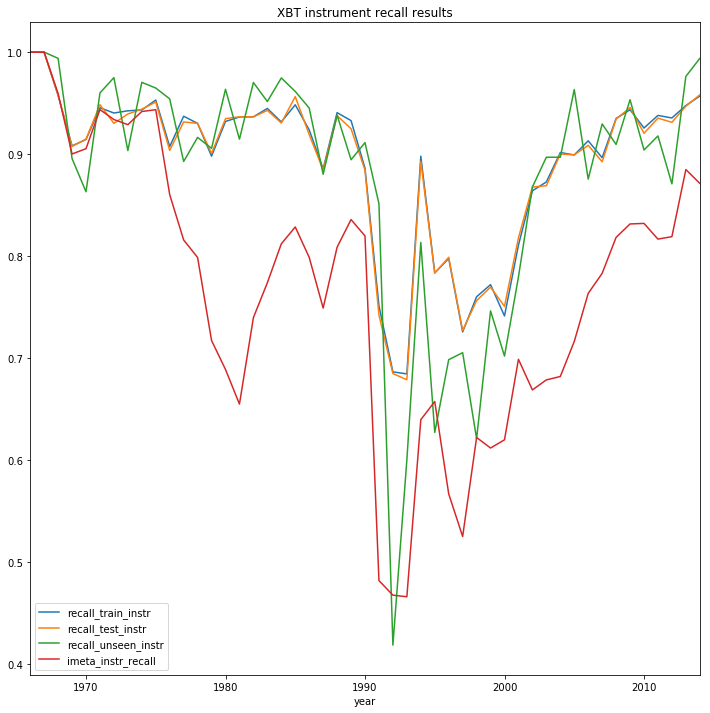

In [41]:
fig_model_recall_results = matplotlib.pyplot.figure('xbt_model_recall', figsize=(12,12))
ax_instr_recall_results = fig_model_recall_results.add_subplot(111, title='XBT instrument recall results')
_ = results_df.plot.line(x='year',y=['recall_train_instr','recall_test_instr', 'recall_unseen_instr', 'imeta_instr_recall'], ax=ax_instr_recall_results)

These results shiow that the simple neural network outperforms iMeta, but is substatially worse than a decision tree approach, while being more costly in training time. The addition of lat/lon did positively impact recall.

In [42]:
results_df['improvement_instr'] = results_df.apply(lambda r1: ((r1['recall_test_instr'] /  r1['imeta_instr_recall'])-1)*100.0 , axis=1)

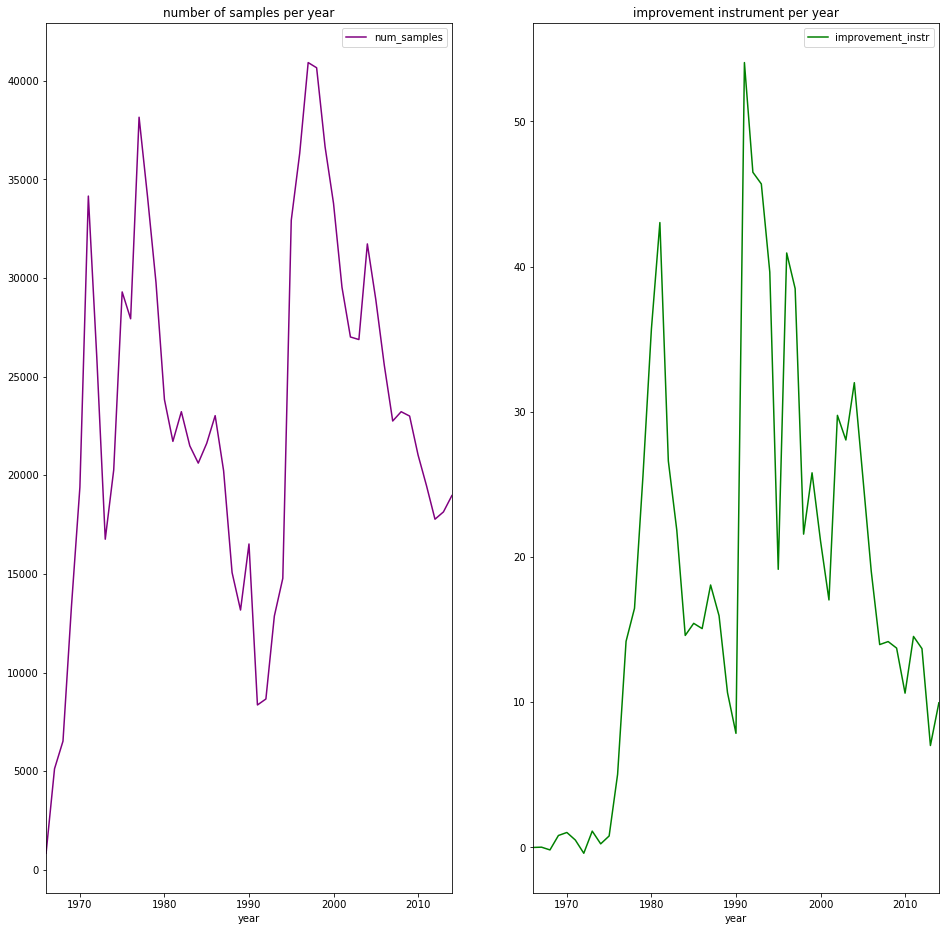

In [43]:
fig_num_samples_per_year = matplotlib.pyplot.figure('fig_num_samples_per_year', figsize=(16,16))
ax_num_samples = fig_num_samples_per_year.add_subplot(121, title='number of samples per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['num_samples'],c='purple' )
ax_num_samples = fig_num_samples_per_year.add_subplot(122, title='improvement instrument per year')
_ = results_df.plot.line(ax=ax_num_samples, x='year',y=['improvement_instr'], c='green' )


In [44]:
results_df.to_csv(os.path.join(result_dir,result_fname_template.format(classifier=classifier_name,
                                                                       suffix=suffix)))

### Outputing the data

To filter based on what profiles we can use for predicting, we need some way of checking each profile we create these checkers from the labelled dataset, because the subset of data that was used for training determines what subset is valid for prediction. For example, if a country is not present in the training data, then the prediction function won't be able to handle that profile to predict a probe model and manufacturer. Profiles that are not handled by the trained classifier will get the label "UNKNOWN".


In [45]:
# checker functions check each element of the profile metadata that could be a problem. The checkers are constructed from the labelled data subset.
checkers_labelled = {f1: c1 for f1, c1 in xbt_labelled.get_checkers().items() if f1 in input_feature_names}

In [46]:
result_feature_name = 'instrument_res_dt'

In [47]:
xbt_predictable = xbt_full_dataset.filter_predictable(checkers_labelled)

In [48]:
res_ml1 = clf_dt_instr1.predict(xbt_predictable.filter_features(input_feature_names).get_ml_dataset()[0])
res2 = list(xbt_labelled._feature_encoders['instrument'].inverse_transform(res_ml1).reshape(-1))

In [49]:
xbt_predictable.xbt_df[result_feature_name] = res2

In [50]:
xbt_full_dataset.merge_features(xbt_predictable, [result_feature_name],
                               fill_values = {result_feature_name: UNKNOWN_STR},
                               feature_encoders={result_feature_name: xbt_labelled._feature_encoders['instrument']},
                               target_encoders={result_feature_name: xbt_labelled._target_encoders['instrument']},
                               output_formatters={result_feature_name: cat_output_formatter})

In [51]:
xbt_full_dataset.output_data(os.path.join(output_dir, output_fname_template.format(classifier=classifier_name,
                                                                                  suffix=suffix)),
                             target_features=[result_feature_name])

## Summary
The combination of reduced accuracy in terms of recall and increased training time compared to decision trees suggest that simple neural networks like those that can be created with the MLPClassifier scikit-learn class, are not a good fit for this problem. It would be interesting to see if more advanced neural network implementations, like in libraries such as Tensorflow/Keras or PyTorch, give better results.